# Implementation of Neural Network Classification on IDS2017 Dataset
Using Method Described in *"Traffic Analysis Based Identification of Attacks"* found [here](http://cecs.louisville.edu/ry/Traffic.pdf).

Uses scikit-learn MLP learner to classify [IDS-2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html) and analyze results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import MLPClassifier

## Data Preprocessing
Define a data loading function, categorical variables are converted into numerical using categorical codes.

The balance functions aims at giving more weight to web attacks and infiltration by replicating them.

In [2]:
def balance(data, cols=None, ratio = 5):
    
        
    L = ['Web Attack � Brute Force','Web Attack � XSS','Infiltration','Web Attack � Sql Injection',
         'Heartbleed']
    
    reps = [ratio if val in L else 1 for val in data[' Label']]
    data = data.loc[np.repeat(data.index.values, reps)]
        
    return data

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def load_data(file_path, cols=None, bal = False):
    
    data = pd.read_csv(file_path)
    
    data.dropna(inplace=True)
    
    
  
    for col in data.columns: 
        if(col == ' Label') : print("Ignore column Label")
        
        else : data = data.loc[(data[col] < np.finfo(np.float64).max )] 
            
    
    if bal : data = balance(data)        
    
    """  
    #Check test to ensure wrong data were properly removed. 
    
    for col in data.columns:
        if (sum(data[col] =='NaN') > 0):
            print("Error : still NaN values in data \n")
        
        if(sum(data[col] =='Infinity') >0):
            print("Error : still Infinity values in data \n")
        
    """ 
        
    # Shuffle data
    
    print(data[' Label'].value_counts())

    data = data.sample(frac=1).reset_index(drop=True)
      
    labels = data[' Label']        #Careful : blank space in ' Label' for IDS2017: won't work if you miss it
    data.drop(' Label', axis=1, inplace=True)
    
    
        
    return [data, labels]

## Slicing IDS 2017 to Training Set and Test Set

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def load_slice_data(file_path, cols=None):
    
    data = pd.read_csv(file_path)
    
    data.dropna(inplace=True)   
  
    data = data.sample(frac=1).reset_index(drop=True)
   
    return data

In [5]:
train_data = load_slice_data('concat.csv')


In [6]:
print(train_data.shape)

(2829385, 79)


In [7]:

chunk = int (train_data.shape[0]*75/100)  #ratio = 75 %  /  25% 
train_set =train_data.iloc[:chunk,:]
test_set = train_data.iloc[chunk:,:]

print(train_set.shape)
print(test_set.shape)


test_set.head()

(2122038, 79)
(707347, 79)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2122038,80,98305944,7,6,361,11595,355,0,51.571429,133.818107,...,20,992.0,0.0,992,992,98200000.0,0.0,98200000,98200000,DoS Hulk
2122039,53,30464,1,1,56,94,56,56,56.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2122040,53,215,2,2,92,248,46,46,46.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2122041,53,30276,1,1,47,63,47,47,47.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2122042,80,26115,5,0,30,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS


## Exporting dataframes to csv files

In [8]:
train_set.to_csv("train_IDS2017.csv", index=False)
test_set.to_csv("test_IDS2017.csv", index=False)

## Reducing the number of benign frames

In [5]:
def load_reduce_data(file_path, ratio = 2, cols=None):
    
    data = pd.read_csv(file_path)
 
    
    #Reduce the number of benign frames to increase recall
    
    # Reduction ratio ~= ratio . 
    
    L = []
    count = 0
    for i, row in data.iterrows():
      
        if (count != ratio) & (row[' Label']  == "BENIGN"):
             L.append(i)
            
        elif count == ratio :                
            count = -1
        
        count += 1 

            
    data.drop(L,inplace=True)
    
    data = data.sample(frac=1).reset_index(drop=True)
        
    return data

## Saving the new csv files

In [44]:
train_data = load_reduce_data('train_IDS2017.csv')
train_data.to_csv("train_reduced_IDS2017.csv", index=False)

In [26]:
test_data = load_reduce_data('test_IDS2017.csv')
test_data.to_csv("test_reduced_IDS2017.csv", index=False)

## Neural Network Training and Testing
Define a function that trains the model and evaluates it on the test data, outputs accuracy on the training and test sets.

In [6]:
def train_clf(train_data, train_labels):
    bin_labels = train_labels.apply(lambda x: x if x =='BENIGN' else 'ANOMALY')
    clf = MLPClassifier(hidden_layer_sizes=(78,39,19,8,3), alpha=.7,
                        beta_1=.8, beta_2=.8)
    clf.fit(train_data, bin_labels)
    
    train_preds = clf.predict(train_data)
    
    TP = sum((train_preds == bin_labels) & (bin_labels == 'ANOMALY'))
    FP = sum((train_preds != bin_labels) & (bin_labels == 'BENIGN'))
    
    TN = sum((train_preds == bin_labels) & (bin_labels == 'BENIGN'))
    FN = sum((train_preds != bin_labels) & (bin_labels == 'ANOMALY'))
    
    train_acc = sum(train_preds == bin_labels)/len(train_preds)
    
    train_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    train_recall = TP/(TP + FN) #Note : TN + FN = sum(train_preds != bin_labels)
    
    train_f = 2 * train_precision * train_recall /(train_precision + train_recall)
    
    print("Accuracy on training set: {0:1%}".format(train_acc))
    print("Precision on training set: {0:1%}".format(train_precision))
    print("Recall on training set: {0:1%}".format(train_recall))
    print("F measure on training set: {0:1%}".format(train_f))

    return clf

In [7]:
def test_clf(test_data, test_labels, clf):
    bin_labels = test_labels.apply(lambda x: x if x =='BENIGN' else 'ANOMALY')
    test_preds = clf.predict(test_data)
    
    TP = sum((test_preds == bin_labels) & (bin_labels == 'ANOMALY'))
    FP = sum((test_preds != bin_labels) & (bin_labels == 'BENIGN'))
    
    TN = sum((test_preds == bin_labels) & (bin_labels == 'BENIGN'))
    FN = sum((test_preds != bin_labels) & (bin_labels == 'ANOMALY'))
    
    test_acc = sum(test_preds == bin_labels)/len(test_preds)
    
    test_precision = TP/ (TP + FP) #Note: TP + FP = sum(train_preds == bin_labels)
    
    test_recall = TP/(TP + FN) if (TP+FN > 0) else 1 #Note : TP + FN = sum(train_preds != bin_labels)
    
    test_f = 2 * test_precision * test_recall /(test_precision + test_recall)
    print("Accuracy on test set: {0:1%}".format(test_acc))
    print("Precision on test set: {0:1%}".format(test_precision))
    print("Recall on test set: {0:1%}".format(test_recall))
    print("F measure on test set: {0:1%}".format(test_f))
    return test_preds

# Training Classifier

In [11]:
train_data, train_labels = load_data('train_reduced_IDS2017.csv')
train_data.head()

Ignore column Label
BENIGN                        567934
DoS Hulk                      172651
PortScan                      119348
DDoS                           96011
DoS GoldenEye                   7729
FTP-Patator                     5933
SSH-Patator                     4454
DoS slowloris                   4362
DoS Slowhttptest                4185
Bot                             1498
Web Attack � Brute Force        1149
Web Attack � XSS                 489
Infiltration                      26
Web Attack � Sql Injection        19
Heartbleed                         9
Name:  Label, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,80,98762285,8,6,354,11595,354,0,44.25,125.157900,...,1,32,975.0,0.0,975,975,98700000.0,0.0,98700000,98700000
1,80,5717599,3,1,0,0,0,0,0.00,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
2,53,30636,2,2,68,194,34,34,34.00,0.000000,...,1,32,0.0,0.0,0,0,0.0,0.0,0,0
3,80,1,2,0,0,0,0,0,0.00,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
4,51949,83823264,6,10,11607,68,5840,0,1934.50,2375.523332,...,4,20,21853.0,0.0,21853,21853,41900000.0,45600000.0,74100000,9659179


In [12]:
print(train_data.shape)

(985797, 78)


In [13]:
#Following line to train on a smaller dataset:
#train_data, train_labels = train_data[::5] , train_labels[::5]

clf = train_clf(train_data, train_labels)


Accuracy on training set: 96.955053%
Precision on training set: 95.325633%
Recall on training set: 97.602564%
F measure on training set: 96.450662%


# Testing

In [14]:
test_data, test_labels = load_data('test_IDS2017.csv')
test_data.head()

Ignore column Label
BENIGN                        568273
DoS Hulk                       57473
PortScan                       39456
DDoS                           32014
DoS GoldenEye                   2564
FTP-Patator                     2002
SSH-Patator                     1443
DoS slowloris                   1434
DoS Slowhttptest                1314
Bot                              458
Web Attack � Brute Force         358
Web Attack � XSS                 163
Infiltration                      10
Heartbleed                         2
Web Attack � Sql Injection         2
Name:  Label, dtype: int64


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,53,227,2,2,60,264,30,30,30.000000,0.000000,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,80,2001875,5,0,30,0,6,6,6.000000,0.000000,...,4,20,0.0,0.0,0,0,0.0,0.0,0,0
2,443,171612,11,9,666,6559,421,0,60.545455,127.801693,...,5,32,0.0,0.0,0,0,0.0,0.0,0,0
3,443,3,2,0,31,0,31,0,15.500000,21.920310,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
4,80,44080567,4,3,239,0,231,0,59.750000,114.228937,...,2,32,721.0,0.0,721,721,44100000.0,0.0,44100000,44100000


In [15]:
print(test_data.shape)

(706966, 78)


In [16]:
test_preds = test_clf(test_data, test_labels, clf)

Accuracy on test set: 96.734779%
Precision on test set: 87.233412%
Recall on test set: 97.646601%
F measure on test set: 92.146750%


## Testing over each day

In [17]:
L = [  "Monday-WorkingHours.pcap_ISCX.csv", "Tuesday-WorkingHours.pcap_ISCX.csv",
"Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",  "Wednesday-workingHours.pcap_ISCX.csv",
"Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",  "Friday-WorkingHours-Morning.pcap_ISCX.csv",
"Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",  "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"]

for file in L:
    print(file.split("-")[0])
    day_data, day_labels = load_data(file)
    print(day_data.shape)
    test_clf(day_data, day_labels, clf)
    print("#########################")
    print("")
    

    

Monday
Ignore column Label
BENIGN    529481
Name:  Label, dtype: int64
(529481, 78)
Accuracy on test set: 98.630357%
Precision on test set: 0.000000%
Recall on test set: 100.000000%
F measure on test set: 0.000000%
#########################

Tuesday
Ignore column Label
BENIGN         431813
FTP-Patator      7935
SSH-Patator      5897
Name:  Label, dtype: int64
(445645, 78)
Accuracy on test set: 97.475345%
Precision on test set: 55.186272%
Recall on test set: 99.277039%
F measure on test set: 70.938913%
#########################

Thursday
Ignore column Label
BENIGN                        168051
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name:  Label, dtype: int64
(170231, 78)
Accuracy on test set: 97.501630%
Precision on test set: 8.523409%
Recall on test set: 9.770642%
F measure on test set: 9.104510%
#########################

Wednesday
Ignore column Label
BENIGN              439683
DoS Hulk            230124
DoS Gold

## To test

In [18]:
ATTACKS = {
    'BENIGN': 'BENIGN',
        
    'DoS Hulk': 'DoS',
    'DDoS': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'Bot' : 'DoS',
   

    'PortScan' : 'Probe',
    

    'Web Attack � Brute Force' : 'Web',
    'Web Attack � XSS' : 'Web',
    'Web Attack � Sql Injection': 'Web',
   

    'FTP-Patator' : 'Infiltration',
    'SSH-Patator' : 'Infiltration',
    'Heartbleed' : 'Infiltration',
    'Infiltration' : 'Infiltration'
}

test_cat_labels = test_labels.apply(lambda x: ATTACKS[x])
cats = {'Web':[0, 0], 'DoS':[0, 0], 'Infiltration':[0, 0], 'Probe':[0, 0], 'BENIGN':[0, 0]}
for cat, pred in zip(test_cat_labels, test_preds):
    cats[cat][pred=='BENIGN'] += 1
print(cats)

for key, values in cats.items():
    print('\n' + key)
    total = sum(values)
    print('Total rows: {}'.format(total))
    if key == 'BENIGN':
        correct = values[1]
    else:
        correct = values[0]
    print('Percent correctly classified: {:.1%}'.format(correct/total))

{'Web': [50, 473], 'DoS': [92636, 2621], 'Infiltration': [3416, 41], 'Probe': [39327, 129], 'BENIGN': [19820, 548453]}

Web
Total rows: 523
Percent correctly classified: 9.6%

DoS
Total rows: 95257
Percent correctly classified: 97.2%

Infiltration
Total rows: 3457
Percent correctly classified: 98.8%

Probe
Total rows: 39456
Percent correctly classified: 99.7%

BENIGN
Total rows: 568273
Percent correctly classified: 96.5%


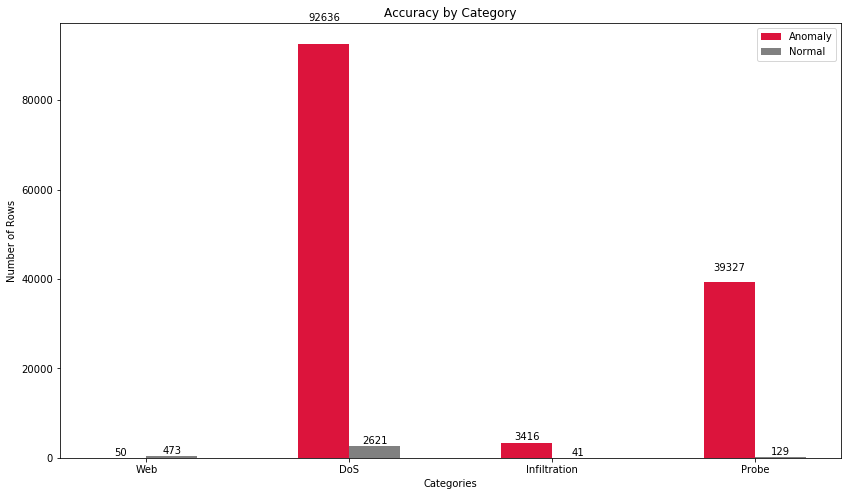

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
ind = np.arange(4)
width = .25
fig, ax = plt.subplots(figsize=(14,8))
del cats['BENIGN']
anoms = [values[0] for key, values in cats.items()]
norms = [values[1] for key, values in cats.items()]
rect1 = ax.bar(ind, anoms, width, color='crimson')
rect2 = ax.bar(ind + width, norms, width, color='grey')
ax.set_ylabel('Number of Rows')
ax.set_title('Accuracy by Category')
ax.set_xlabel('Categories')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(cats.keys())
ax.legend((rect1[0], rect2[0]), ('Anomaly', 'Normal'))

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rect1, ax)
autolabel(rect2, ax)